# 1. Error analysis for nbs from github - the stack v1

https://huggingface.co/datasets/bigcode/the-stack-dedup/tree/main/data/jupyter-notebook


In [2]:
# read in all errors from the file
import pandas as pd

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]
df2_err.head()

,fname,ename,evalue,traceback
0,00000-101-cookie-clicker-v2-checkpoint.ipynb,KeyboardInterrupt,NaN,['--------------------------------------------...
1,00000-1012-demand-forecasting-data-prep-from-s...,OperationalError,"FATAL: no pg_hba.conf entry for host ""75.166....",['--------------------------------------------...
2,00000-1017-heatmapseq2seq.ipynb,ValueError,"x and y must have same first dimension, but ha...",['--------------------------------------------...
3,00000-1023-crawler-20190515-20190516.ipynb,ConnectionError,HTTPSConnectionPool(host='www.backpackers.com....,['--------------------------------------------...
4,00000-1033-peer-solution-predicting-survival-t...,URLError,<urlopen error [Errno 11001] getaddrinfo failed>,['--------------------------------------------...


In [3]:
df2_err.count()

fname        177540
ename        177396
evalue       158707
traceback    177540
dtype: int64

In [6]:
df2_err["fname"].nunique()

109063

In [5]:
df2_err["ename"].nunique()

1520

<Axes: xlabel='ename'>

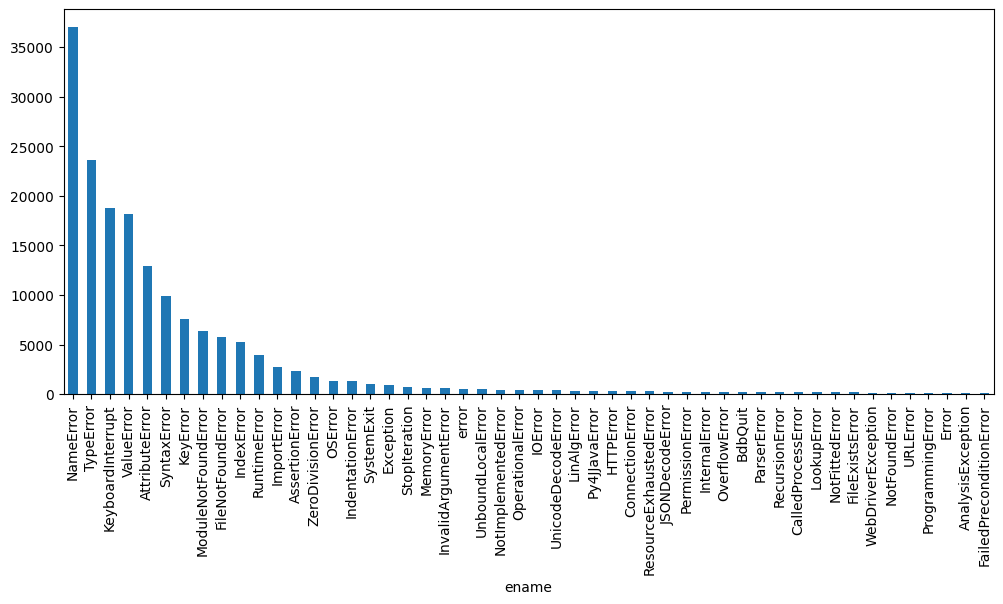

In [7]:
df2_err["ename"].groupby([df2_err["ename"]]).count().sort_values(ascending=0)[:50].plot(kind="bar", figsize=(12,5))

<Axes: xlabel='ename'>

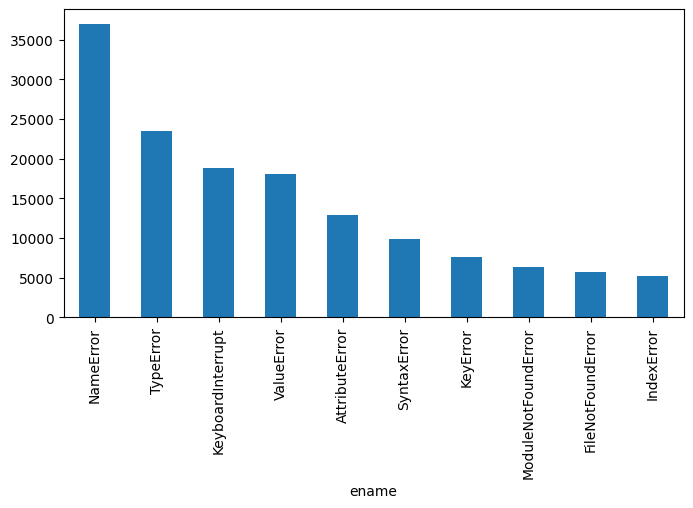

In [8]:
df2_err["ename"].groupby([df2_err["ename"]]).count().sort_values(ascending=0)[:10].plot(kind="bar", figsize=(8,4))

## 1.1 Clustering

In [1]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3.csv', encoding='utf-8')
df2_err = df2_err[df2_err['language']=='python'][['fname','ename','evalue','traceback']]

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### preprocess - tokenize

In [2]:
df2_err['evalue_tokenized'] = df2_err['evalue'].apply(cluster_util.preprocess_text)

In [4]:
df2_err.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evaluetokenized.csv", index=False, encoding='utf-8')

### 1.1.1 Clustering Value errors

load tokenized error dataset, evalue_tokenized

In [1]:
import pandas as pd 
import cluster_util

df2_err = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_all_p3_evaluetokenized.csv', encoding='utf-8')
df2_err = df2_err[['ename','evalue','evalue_tokenized']]

In [9]:
df2_err_ename = df2_err[df2_err['ename']=='ValueError']
err_descs = df2_err_ename['evalue_tokenized'].values.astype('U')

#### vectorization
##### 1. tfidf
too high dimension (18148, 7791)

In [12]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

(18148, 7791)

In [15]:
import numpy as np

with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_tfidf.txt', 'wb') as f:
    np.save(f, X_tfidf)

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector (18148, 384)

In [21]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(18148, 384)

In [22]:
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers.txt', 'wb') as f:
    np.save(f, X_transformers)

##### 3. word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

using GloVe (18148, 200)

In [24]:
glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove.shape

Loaded 400000 word vectors from GloVe.


(18148, 200)

In [25]:
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_glove.txt', 'wb') as f:
    np.save(f, X_glove)

#### clustering with vectorized error values
##### 1. tfidf

In [1]:
import pandas as pd
import numpy as np 
import cluster_util

df2_err_ename = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv', encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## kmeans

In [3]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_tfidf, K_range = K_range)

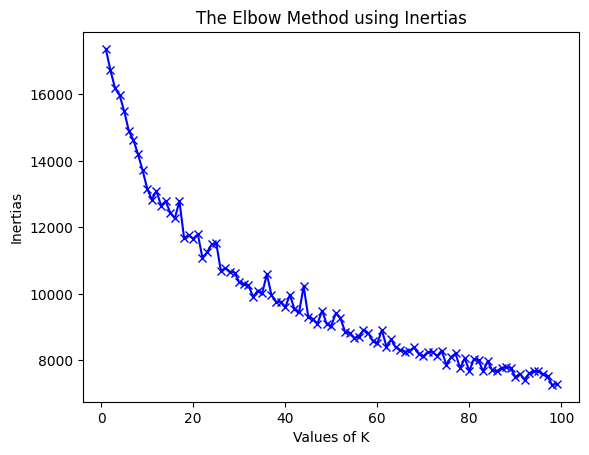

In [4]:
import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [7]:
num_clusters = 52
res = cluster_util.cluster_kmeans(X_tfidf, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 978 samples
                                                  evalue  cluster
9175         invalid literal for int() with base 10: 'e'        0
17183    invalid literal for int() with base 10: 'hello'        0
4648   invalid literal for int() with base 10: '20141...        0
15464  invalid literal for int() with base 10: '2005-...        0
3412   invalid literal for int() with base 10: '1 or ...        0
5464      invalid literal for int() with base 10: 'hola'        0
10516       invalid literal for int() with base 10: 'Hi'        0
12315      invalid literal for int() with base 10: 'jim'        0
17968        invalid literal for int() with base 11: 'B'        0
11810         invalid literal for int() with base 10: ''        0


cluster 1 has 878 samples
                                                  evalue  cluster
9700           could not convert string to float: '-45s'        1
9069      could not convert string to float: 'you suyck'        1
6765              coul

In [9]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_tfidf_kmeans52"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

In [ ]:
## OPTICS

In [5]:
res = cluster_util.cluster_optics(X_tfidf, min_samples = 50)

Estimated no. of clusters: 52
Estimated no. of noise points: 9212


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [10]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(52, df2_err_ename[['evalue','cluster']])

cluster 0 has 309 samples
                                                  evalue  cluster
14837  x and y must have same first dimension, but ha...        0
12637  x and y must have same first dimension, but ha...        0
10683  x and y must have same first dimension, but ha...        0
10407  x and y must have same first dimension, but ha...        0
9655   x and y must have same first dimension, but ha...        0
2237   x and y must have same first dimension, but ha...        0
10157  x and y must have same first dimension, but ha...        0
383    x and y must have same first dimension, but ha...        0
15478  x and y must have same first dimension, but ha...        0
5224   x and y must have same first dimension, but ha...        0


cluster 1 has 103 samples
                                   evalue  cluster
16584  x and y must have the same length.        1
757         x and y must be the same size        1
13216       x and y must be the same size        1
1991        x an

In [11]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_tfidf_optics52"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

In [ ]:
## dbscan

In [ ]:
cluster_util.eps_dbscan(50, X_tfidf)

In [112]:
res = cluster_util.cluster_dbscan(X_tfidf, eps=0.99, min_samples=100)

Estimated no. of clusters: 22
Estimated no. of noise points: 8439


In [113]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(22, df2_err_ename[['evalue','cluster']])

cluster 0 has 795 samples
                                                   evalue  cluster
54541   all the input array dimensions except for the ...        0
12010   all the input array dimensions except for the ...        0
47987   x and y must have same first dimension, but ha...        0
54959   x and y must have same first dimension, but ha...        0
2209                             a must be greater than 0        0
119638  x and y can be no greater than 2-D, but have s...        0
153684                     arrays must all be same length        0
81474   all the input array dimensions for the concate...        0
62714   x and y must have same first dimension, but ha...        0
161612  all the input arrays must have same number of ...        0


cluster 1 has 707 samples
                                                 evalue  cluster
60942   not enough values to unpack (expected 2, got 1)        1
54480            too many values to unpack (expected 6)        1
32546         

In [114]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_tfidf"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

##### 2. sentence transformers

In [12]:
import pandas as pd
import numpy as np 
import cluster_util

df2_err_ename = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv', encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)

In [ ]:
## kmeans

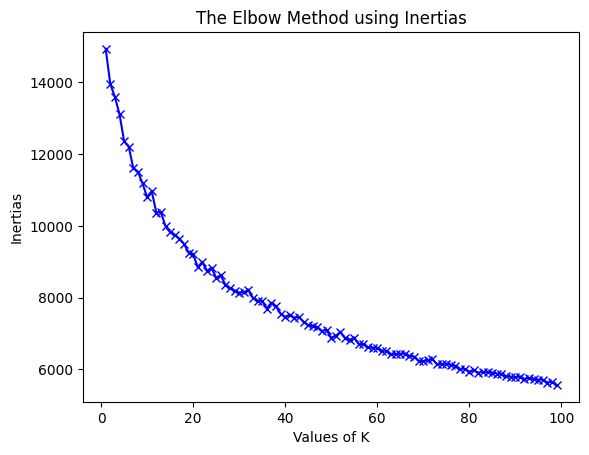

In [15]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_transformers, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [18]:
num_clusters = 53
res = cluster_util.cluster_kmeans(X_transformers, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 981 samples
                                                  evalue  cluster
4566      invalid literal for int() with base 10: '234b'        0
13747   invalid literal for int() with base 10: '¿¥3799'        0
14012     invalid literal for int() with base 10: '1.5%'        0
3208   invalid literal for int() with base 10: 'Люк, ...        0
18118         invalid literal for int() with base 10: ''        0
9469       invalid literal for int() with base 10: 'abc'        0
10905        invalid literal for int() with base 10: 'a'        0
16104    invalid literal for int() with base 10: 'salut'        0
16991  invalid literal for int() with base 10: '2ae25...        0
10147       invalid literal for int() with base 10: 'ls'        0


cluster 1 has 305 samples
                                                  evalue  cluster
7687   The truth value of an array with more than one...        1
4975   The truth value of an array with more than one...        1
17804  The truth value

In [19]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_transformers_kmeans53"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

In [ ]:
## OPTICS

In [16]:
res = cluster_util.cluster_optics(X_transformers, min_samples = 50)

Estimated no. of clusters: 53
Estimated no. of noise points: 9495


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [20]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(53, df2_err_ename[['evalue','cluster']])

cluster 0 has 283 samples
                                                  evalue  cluster
14866  x and y must have same first dimension, but ha...        0
17424  x and y must have same first dimension, but ha...        0
16346  x and y must have same first dimension, but ha...        0
17849  x and y must have same first dimension, but ha...        0
210    x and y must have same first dimension, but ha...        0
12025  x and y must have same first dimension, but ha...        0
4501   x and y must have same first dimension, but ha...        0
5008   x and y must have same first dimension, but ha...        0
4319   x and y must have same first dimension, but ha...        0
16310  x and y must have same first dimension, but ha...        0


cluster 1 has 105 samples
                                     evalue  cluster
6843          x and y must be the same size        1
13252         x and y must be the same size        1
3729          x and y must be the same size        1
13275   

In [21]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_transformers_optics53"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

In [ ]:
## dbscan

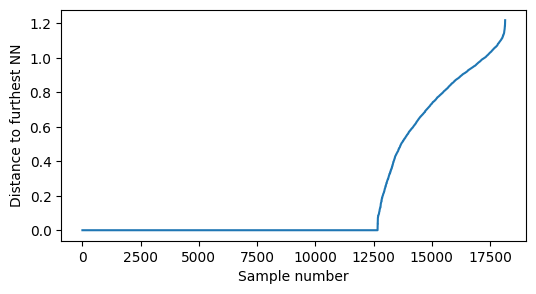

In [23]:
cluster_util.eps_dbscan(50, X_transformers)

In [25]:
res = cluster_util.cluster_dbscan(X_transformers, eps=0.001, min_samples=50)

Estimated no. of clusters: 41
Estimated no. of noise points: 10721


In [121]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(16, df2_err_ename[['evalue','cluster']])

cluster 0 has 4199 samples
                                                   evalue  cluster
182831  x and y must have same first dimension, but ha...        0
54956   operands could not be broadcast together with ...        0
149471  Error when checking target: expected conv2d_7 ...        0
130626    Length of values does not match length of index        0
132761  x and y can be no greater than 2-D, but have s...        0
72060   shape mismatch: value array of shape (301,3) c...        0
78723   x and y must have same first dimension, but ha...        0
122780  cannot copy sequence with size 24 to array axi...        0
12104   Input 0 of layer "SDropout_0" is incompatible ...        0
130057  Error when checking target: expected dense_31 ...        0


cluster 1 has 722 samples
                                                 evalue  cluster
28038   not enough values to unpack (expected 3, got 2)        1
121991  not enough values to unpack (expected 3, got 1)        1
179535       

In [122]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_transformers"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

##### 3. word embeddings - GloVe

In [26]:
import pandas as pd
import numpy as np 
import cluster_util

df2_err_ename = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv', encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

In [27]:
## kmeans

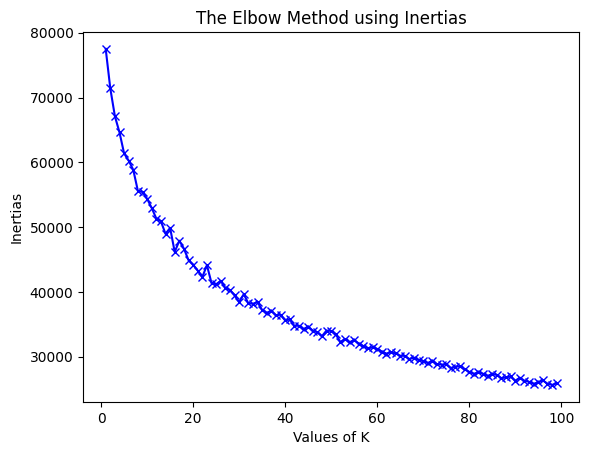

In [28]:
K_range = range(1,100)
inertias = cluster_util.elbow_for_kmean(X_glove, K_range = K_range)

import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method using Inertias')
plt.show()

In [30]:
num_clusters = 55
res = cluster_util.cluster_kmeans(X_glove, n_clusters=num_clusters)
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(num_clusters, df2_err_ename[['evalue','cluster']])

cluster 0 has 983 samples
                                                  evalue  cluster
7277          invalid literal for int() with base 10: ''        0
14630        invalid literal for int() with base 10: 'a'        0
7662   invalid literal for int() with base 10: '/home...        0
10222        invalid literal for int() with base 10: 'a'        0
8432       invalid literal for int() with base 10: '3.4'        0
13974   invalid literal for int() with base 10: 'pixel0'        0
18119         invalid literal for int() with base 10: ''        0
16362  invalid literal for int() with base 10: '250Em...        0
12321        invalid literal for int() with base 10: 'C'        0
16402    invalid literal for int() with base 10: '안녕하세요'        0


cluster 1 has 417 samples
                                                  evalue  cluster
8191   Error when checking target: expected max_pooli...        1
15032  Buffer dtype mismatch, expected 'Python object...        1
16440  Buffer dtype mi

In [31]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_glove_kmeans55"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

In [ ]:
## OPTICS

In [29]:
res = cluster_util.cluster_optics(X_glove, min_samples = 50)

Estimated no. of clusters: 55
Estimated no. of noise points: 9519


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [32]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(55, df2_err_ename[['evalue','cluster']])

cluster 0 has 309 samples
                                                  evalue  cluster
4323   x and y must have same first dimension, but ha...        0
14920  x and y must have same first dimension, but ha...        0
6355   x and y must have same first dimension, but ha...        0
332    x and y must have same first dimension, but ha...        0
13872  x and y must have same first dimension, but ha...        0
16038  x and y must have same first dimension, but ha...        0
1390   x and y must have same first dimension, but ha...        0
12974  x and y must have same first dimension, but ha...        0
17067  x and y must have same first dimension, but ha...        0
7957   x and y must have same first dimension, but ha...        0


cluster 1 has 96 samples
                              evalue  cluster
13434  x and y must be the same size        1
3052   x and y must be the same size        1
17039  x and y must be the same size        1
17513  x and y must be the same size 

In [33]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_glove_optics55"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

In [ ]:
## dbscan

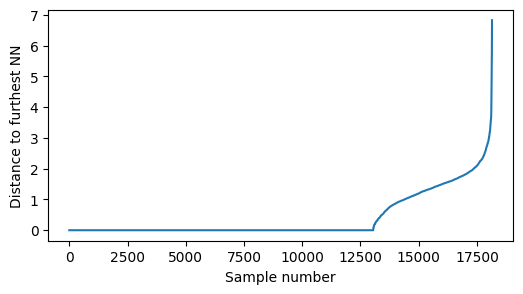

In [75]:
# Some studies use DBSCAN to classify logs, but it seems to work for more structured data

# X_glove_scaled = cluster_util.scaling(X_glove)
cluster_util.eps_dbscan(100, X_glove)

In [124]:
res = cluster_util.cluster_dbscan(X_glove, eps=1.3, min_samples=100)

Estimated no. of clusters: 20
Estimated no. of noise points: 7869


In [125]:
df2_err_ename.loc[:,"cluster"] = res
cluster_util.print_clusters(20, df2_err_ename[['evalue','cluster']])

cluster 0 has 4403 samples
                                                   evalue  cluster
72945          could not convert string to float: 'a19.5'        0
50304   cannot resize an array that references or is r...        0
75866   could not convert string to float: '01 ONE FAM...        0
96561   A `Concatenate` layer requires inputs with mat...        0
22115   Error when checking target: expected conv2d_13...        0
141898  This model has not yet been built. Build the m...        0
115895  Cannot set a frame with no defined index and a...        0
167231  in user code:\n\n    /Users/I335620/opt/anacon...        0
90306         could not convert string to float: 'Toyota'        0
146799  y should be a 1d array, got an array of shape ...        0


cluster 1 has 703 samples
                                                  evalue  cluster
43281    not enough values to unpack (expected 2, got 0)        1
15157             too many values to unpack (expected 6)        1
126071    

In [126]:
df2_err_ename = df2_err_ename.rename(columns={"cluster": "cluster_dbscan_glove"})
df2_err_ename.to_csv("C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv", index=False, encoding='utf-8')

#### validate vectorization and clustering methods

In [ ]:
import pandas as pd
import numpy as np
import cluster_util

df2_err_ename = pd.read_csv('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_cluster_nameerror.csv', encoding='utf-8')
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_tfidf.txt', 'rb') as f:
    X_tfidf = np.load(f)
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_transformers.txt', 'rb') as f:
    X_transformers = np.load(f)
with open('C:/Users/yirwa29/Downloads/Dataset-Nb/nberror_g_evalue_embeddings_glove.txt', 'rb') as f:
    X_glove = np.load(f)

##### 1. vectorization

In [ ]:
from sklearn.metrics import silhouette_score

def eval_cluster_silhouette(X_array, y_predicted):
    return silhouette_score(X_array, y_predicted)

In [ ]:
# levenshtein_similarity

import editdistance

def statistics(df, target, groups):
        patterns = []
        for index, row in groups.iterrows():
            messages = df.loc[row['indices'], target].values
            patterns.append(cluster_statistics(index, row, messages))
        return pd.DataFrame(patterns, columns=STATISTICS)\
                    .round(2)\
                    .sort_values(by='cluster_size', ascending=False)
    
def cluster_statistics(item, row, messages):
        similarity = levenshtein_similarity_1_to_n(messages)
        return {'cluster_name': item,
                'cluster_size': row['cluster_size'],
                'pattern': row['pattern'],
                'mean_similarity': np.mean(similarity),
                'std_similarity': np.std(similarity)}
    
def levenshtein_similarity_1_to_n(many, single = None):
    if len(many) == 0:
        return 1.
    if single is None:
        single, many = many[0], many[1:]
    if len(many) == 0:
        return [1.0]
    return [levenshtein_similarity(single, item) for item in many]

def levenshtein_similarity(a, b):
    return 1 - editdistance.eval(a, b) / max(len(a), len(b))

In [50]:
df2_err_ename['cluster_tfidf_kmeans52']

(18148, 7791)

In [53]:
ss_km_tfidf = eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_tfidf_kmeans52'])
print(f'Silhouette score for KMeans with tfidf: {ss_km_tfidf}')

Silhouette score for KMeans with tfidf: 0.34746861457824707


In [51]:
ss_km_transformers = eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_transformers_kmeans53'])
print(f'Silhouette score for KMeans with transformers: {ss_km_transformers}')

Silhouette score for KMeans with transformers: 0.35049466820583014


In [54]:
ss_km_glove = eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_glove_kmeans55'])
print(f'Silhouette score for KMeans with glove: {ss_km_glove}')

Silhouette score for KMeans with glove: 0.2917187809944153


In [39]:
df2_err_ename.columns

Index(['fname', 'ename', 'evalue', 'traceback', 'evalue_tokenized',
       'cluster_tfidf', 'cluster_transformers', 'cluster_glove',
       'cluster_dbscan_tfidf', 'cluster_dbscan_transformers',
       'cluster_dbscan_glove', 'cluster_tfidf_kmeans52',
       'cluster_tfidf_optics52', 'cluster_transformers_kmeans53',
       'cluster_transformers_optics53', 'cluster_glove_kmeans55',
       'cluster_glove_optics55'],
      dtype='object')

##### 2. clustering methods

In [43]:
ss_km_optics= eval_cluster_silhouette(X_tfidf, df2_err_ename['cluster_tfidf_optics52'])
print(f'Silhouette score for optics with tfidf: {ss_km_optics}')

Silhouette score for optics with tfidf: 0.3806733380711479


In [46]:
ss_optics_transformers = eval_cluster_silhouette(X_transformers, df2_err_ename['cluster_transformers_optics53'])
print(f'Silhouette score for optics with transformers: {ss_optics_transformers}')

Silhouette score for optics with transformers: 0.31153765320777893


In [47]:
ss_optics_glove = eval_cluster_silhouette(X_glove, df2_err_ename['cluster_glove_optics55'])
print(f'Silhouette score for optics with glove: {ss_optics_glove}')

Silhouette score for optics with glove: 0.2655130028796565


#### NameError, evalue

In [6]:
df2_err_ename = df2_err[df2_err['ename']=='NameError']
err_descs = df2_err_ename['evalue'].values.astype('U') # traceback: memory error

In [ ]:
num_clusters = 2
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters) # km_model, res, vectorized_descs
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)

In [7]:
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 50 samples
                              errdesc  cluster
36857     name 'error' is not defined        0
30187     name 'error' is not defined        0
166       name 'error' is not defined        0
17326     name 'error' is not defined        0
694       name 'error' is not defined        0
1979      name 'error' is not defined        0
32475     name 'error' is not defined        0
34312     name 'error' is not defined        0
31205  This is the raised name error.        0
25804     name 'error' is not defined        0


cluster 1 has 36955 samples
                                   errdesc  cluster
7019              name 'df' is not defined        1
31697           name 'tmax' is not defined        1
20632            name 'nlp' is not defined        1
10551             name 'np' is not defined        1
35938             name 'bb' is not defined        1
11316          name 'model' is not defined        1
23866           name 'set1' is not defined        1
5088        

##### Note:

found **ignored** values in evalue column in a cluster, but they seem have evalue in traceback. I extracted those and retried.

##### No obvious clusters found in NameError.

#### TypeError, evalue

In [16]:
df2_err_ename = df2_err[df2_err['ename']=='TypeError']
err_descs = df2_err_ename['evalue'].values.astype('U') # traceback: memory error

In [17]:
num_clusters = 10
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=1000)
# plot the results 
# cluster_util.plot_clusters(vectorized_descs, num_clusters, km_model.labels_)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 1488 samples
                                             errdesc  cluster
11659    can only concatenate str (not "int") to str        0
8625                    'int' object is not iterable        0
4428                    'str' object is not callable        0
12026    can only concatenate str (not "int") to str        0
21289    can only concatenate str (not "int") to str        0
6557           cannot unpack non-iterable int object        0
14131                   'str' object is not callable        0
9622                            must be str, not int        0
9063     can only concatenate str (not "int") to str        0
16412  can only concatenate str (not "float") to str        0


cluster 1 has 2519 samples
                                                 errdesc  cluster
18588  emptyFunction() takes 0 positional arguments b...        1
20039  field() takes 0 positional arguments but 1 was...        1
1419   emptyFunction() takes 0 positional arguments b...        

##### Note:

10 clusters for TypeError:

    1. can only concatenate *something* to str
    2. *something* missing *somenumber* required positional arguments...
    3. *something* object is not callable/iterable/has no len()
    4. *something* object does not support item assignment
    5. others
    6. list/tuple indices must be integers or slices, not str
    7. unhashable type: 'list/dict/slice', can only concatenate list (not "int") to list
    8. unsupported operand type(s) for -: 'str' and '..
    9. *something* object cannot be interpreted/converted...
    10. '<' not supported between instances of 'str' a..

#### AttributeError, evalue

In [23]:
df2_err_ename = df2_err[df2_err['ename']=='AttributeError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [24]:
num_clusters = 2
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=500)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 855 samples
                                                 errdesc  cluster
12354         'DataFrame' object has no attribute 'Date'        0
2388           'DataFrame' object has no attribute 'get'        0
11488     'DataFrame' object has no attribute 'pred_sgd'        0
5408            'DataFrame' object has no attribute 'ix'        0
2060        'DataFrame' object has no attribute 'unique'        0
12927          'DataFrame' object has no attribute 'str'        0
1511          'DataFrame' object has no attribute 'prob'        0
1765   'DataFrame' object has no attribute 'fivegram_...        0
5366           'DataFrame' object has no attribute 'hit'        0
12886       'DataFrame' object has no attribute 'equity'        0


cluster 1 has 12076 samples
                                                 errdesc  cluster
6759           'Person' object has no attribute '__name'        1
7564         module 'numpy' has no attribute 'heaviside'        1
4495                

##### Note: No obvious clusters in AttributeError

#### SyntaxError, evalue

In [25]:
df2_err_ename = df2_err[df2_err['ename']=='SyntaxError']
err_descs = df2_err_ename['evalue'].values.astype('U')

In [27]:
num_clusters = 10
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=500)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 77 samples
                                                errdesc  cluster
9201  keyword can't be an expression (<ipython-input...        0
7244  f-string expression part cannot include a back...        0
2900  keyword can't be an expression (<ipython-input...        0
6632  keyword can't be an expression (<ipython-input...        0
2495  keyword can't be an expression (<ipython-input...        0
7260  can't use starred expression here (<ipython-in...        0
6006  keyword can't be an expression (<ipython-input...        0
7055  can't use starred expression here (<ipython-in...        0
1262  keyword can't be an expression (<ipython-input...        0
461   keyword can't be an expression (<ipython-input...        0


cluster 1 has 58 samples
                                                errdesc  cluster
8337  invalid syntax (<ipython-input-35-fba0d58980c0...        1
7267  'return' outside function (<ipython-input-8-6e...        1
951   invalid syntax (<ipython-input-3

#### Some mixed error types, evalue

In [28]:
df2_err_ename = df2_err[df2_err['ename'].isin(['Error', 'ERROR', 'error'])]
err_descs = df2_err_ename['evalue'].values.astype('U')

In [35]:
num_clusters = 7
_, res, _ = cluster_util.cluster_kmeans(input_texts=err_descs, n_clusters=num_clusters, max_iter=800)
cluster_util.print_clusters(num_clusters, res)

cluster 0 has 220 samples
                                                errdesc  cluster
121   Error in eval(expr, envir, enclos): objet 'hqw...        0
1719  Error in eval(expr, envir, enclos): object 're...        0
1859                                      compile_error        0
1401  Error in eval(expr, envir, enclos): wrong resu...        0
881                                       compile_error        0
1320  Error in eval(expr, envir, enclos): object 'wm...        0
2120  Error in get(name, envir = envir): object 's_l...        0
676   Error in eval(expr, envir, enclos): object 'me...        0
1627  Error in eval(expr, envir, enclos): object '.....        0
2083  Error in eval(expr, envir, enclos): Objekt 'nu...        0


cluster 1 has 140 samples
                                                errdesc  cluster
123   Error in library("scHOT"): there is no package...        1
1063  Error in library(prophet): there is no package...        1
33    Error in library(mxnet): there

## 2. Error analysis for nbs from kaggle


In [1]:
# read in all errors from the file
import pandas as pd

path_err = 'C:/Users/yirwa29/Downloads/Dataset-Nb/nbdata_k_error/nberror_k.csv'
df_err = pd.read_csv(path_err, encoding='utf-8')